# Faster StyleGAN

This is an improvement over the StyleGAN code in the book. The biggest change is that now the code now run in graph mode (non-eager), that's why it is a lot faster to train. The code is also leaner and better structured. This is also compatible with tensorflow 2.5.0.

In [1]:
import os
import random
import math
import gdown
import numpy as np
import matplotlib.pyplot as plt

from enum import Enum
from glob import glob
from functools import partial

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer,Input, LeakyReLU, Reshape
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.layers import InstanceNormalization


CKPT_PATH = './ckpt'
RESULT_PATH = './results'
os.makedirs(CKPT_PATH, exist_ok=True)
os.makedirs(RESULT_PATH, exist_ok=True)

In [2]:
'''
num_devices = 1

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[2], True)
tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
'''

4 Physical GPUs, 1 Logical GPU


# Prepare Dataset

In [3]:
''' 
url = "https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL" 
gdown.download(url, 'celeba_hq.zip', quiet=False)
!unzip celeba_hq.zip -d ./celeba_hq
'''

' \nurl = "https://drive.google.com/uc?id=17w_hePC1xO2eX83gAAF8ptKC59mTPQiL" \ngdown.download(url, \'celeba_hq.zip\', quiet=False)\n!unzip celeba_hq.zip -d ./celeba_hq\n'

In [4]:
def load(res, image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [res, res],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    image = (image /127.5) - 1
    return image

BATCH_SIZE = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10:1}
TRAIN_STEP_RATIO = {k: BATCH_SIZE[2]/v for k, v in BATCH_SIZE.items()}

def create_dataset_(data_path, res):
    res_log2 = int(np.log2(res))
    BUFFER_SIZE = 200
    images = glob(data_path)
    random.shuffle(images)
    batch_size = BATCH_SIZE[res_log2]
    tf_list = tf.data.Dataset.from_tensor_slices(images)
    dataset = tf_list.map(partial(load, res),  num_parallel_calls= tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(BUFFER_SIZE).batch(batch_size, drop_remainder=True).repeat()
    return dataset

DATA_PATH = "celeba_hq/train/**/*.jpg"
create_dataset = partial(create_dataset_, DATA_PATH)
    

### Utility function to display images after each epoch

In [5]:
def plot_images(images, log2_res, fname=''):    
    scales = {2:0.5,
             3:1,
             4:2,
             5:3,
             6:4,
             7:5,
             8:6,
             9:7,
             10:8}
    scale = scales[log2_res]
    
    grid_col = min(images.shape[0], int(32//scale))
    grid_row = 1

    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*scale, grid_row*scale))

    for row in range(grid_row):
        ax = axarr if grid_row==1 else axarr[row]
        for col in range(grid_col):
            ax[col].imshow(images[row*grid_col + col])
            ax[col].axis('off')
    plt.show()
    if fname:
        print("image name", fname)
        f.savefig(fname)

## Custom layers and blocks

In [6]:
def fade_in(alpha, a, b):
    
    return alpha * a + (1. - alpha) * b

def wasserstein_loss(y_true, y_pred):
    
    return -tf.reduce_mean(y_true * y_pred)

class PixelNorm(Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon
        
    def call(self, input_tensor):
        return input_tensor / tf.math.sqrt(tf.reduce_mean(input_tensor**2, axis=-1, keepdims=True) + self.epsilon)

def minibatch_std(input_tensor, epsilon=1e-8):
    n, h, w, c = tf.shape(input_tensor)
    group_size = tf.minimum(4, n)
    x = tf.reshape(input_tensor, [group_size, -1, h, w, c]) 
    group_mean, group_var = tf.nn.moments(x, axes=(0), keepdims=False) 
    group_std = tf.sqrt(group_var + epsilon) 
    avg_std = tf.reduce_mean(group_std, axis=[1,2,3], keepdims=True) 
    x = tf.tile(avg_std, [group_size, h, w, 1]) 

    return tf.concat([input_tensor, x], axis=-1) 


class ConvBlock(Layer):
    def __init__(self, out_channels, kernel=3, gain=2, **kwargs):
        super(ConvBlock, self).__init__(kwargs)
        self.kernel = kernel
        self.out_channels = out_channels
        self.gain = gain
        self.pad = kernel!=1
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)        
        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        self.in_channels,
                                        self.out_channels],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.out_channels,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.kernel*self.kernel*self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    def call(self, inputs):
        if self.pad:
            x = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        else:
            x = inputs
        output = tf.nn.conv2d(x, self.scale*self.w, strides=1, padding="VALID") + self.b
        return output
    
class DenseBlock(Layer):
    def __init__(self, units, gain=2, lrmul=1, **kwargs):
        super(DenseBlock, self).__init__(kwargs)
        self.units = units
        self.gain = gain
        self.lrmul = lrmul
        
    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1./self.lrmul)        
        self.w = self.add_weight(shape=[self.in_channels,
                                        self.units],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
        self.b = self.add_weight(shape=(self.units,),
                                initializer='zeros',
                                trainable=True, name='bias')
        
        fan_in = self.in_channels
        self.scale = tf.sqrt(self.gain/fan_in)
        
    @tf.function(experimental_relax_shapes=True)
    def call(self, inputs):
        output = tf.add(tf.matmul(inputs, self.scale*self.w), self.b)
        return output*self.lrmul
    
    
class AddNoise(Layer):
        
    def build(self, input_shape):
        n, h, w, c = input_shape[0]

        initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
        self.B = self.add_weight(shape=[1, 1, 1, c],
                                initializer=initializer,
                                trainable=True, name='kernel')
        
    def call(self, inputs):
        x, noise = inputs
        output = x + self.B * noise
        return output


class AdaIN(Layer):
    def __init__(self, gain=1, **kwargs):
        super(AdaIN, self).__init__(kwargs)
        self.gain = gain
        
    def build(self, input_shapes):
        x_shape = input_shapes[0]
        w_shape = input_shapes[1]

        self.w_channels = w_shape[-1]
        self.x_channels = x_shape[-1]
        
        self.dense_1 = DenseBlock(self.x_channels, gain=1)
        self.dense_2 = DenseBlock(self.x_channels, gain=1)
        
    @tf.function(experimental_relax_shapes=True)        
    def call(self, inputs):
        x, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        
        output = ys*x + yb
        return output    

In [7]:
def Mapping(num_stages, input_shape=512):
    z = Input(shape=(input_shape))
    w = PixelNorm()(z)
    for i in range(8):
        w = DenseBlock(512, lrmul=0.01)(w)
        w = LeakyReLU(0.2)(w)
    w = tf.tile(tf.expand_dims(w, 1), (1,num_stages,1))        
    return Model(z, w, name='mapping')    
   
    
def GenBlock(filter_num, res, input_shape, is_base):

    input_tensor = Input(shape=input_shape, name=f'g_{res}')
    noise = Input(shape=(res, res, 1), name=f'noise_{res}')
    w = Input(shape=512)
    
    x = input_tensor        

    if not is_base:
        x = UpSampling2D((2,2))(x)
        x = ConvBlock(filter_num, 3)(x)

    x = AddNoise()([x, noise])
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization()(x)
    x = AdaIN()([x, w])

    # ADD NOISE
    x = ConvBlock(filter_num, 3)(x)
    x = AddNoise()([x, noise])
    x = LeakyReLU(0.2)(x)
    x = InstanceNormalization()(x)      
    x = AdaIN()([x, w])

    return Model([input_tensor, w, noise], x, 
                 name=f'genblock_{res}x{res}')

def DiscBase(filter_num, res):

    input_tensor = Input(shape=(res, res, filter_num), name=f'd_{res}')
    x = minibatch_std(input_tensor)
    x = ConvBlock(filter_num, 3)(x)
    x = LeakyReLU(0.2)(x)
    x = Flatten()(x)
    x = DenseBlock(filter_num)(x)
    x = LeakyReLU(0.2)(x)
    x = DenseBlock(1)(x)

    return Model(input_tensor, x, name=f'd_{res}')    

def DiscBlock(filter_num_1, filter_num_2, res):
    return Sequential([Input(shape=(res, res, filter_num_1), name=f'd_{res}'),
                       ConvBlock(filter_num_1, 3),
                       LeakyReLU(0.2),
                       ConvBlock(filter_num_2, 3),
                       LeakyReLU(0.2),
                       AveragePooling2D((2,2))
                      ], name=f'd_{res}')


In [8]:
class Phase(Enum):
    TRANSITION = 1
    STABLE = 2

# Build StyleGAN

In [9]:
class StyleGAN(tf.keras.Model):
    @staticmethod
    def log2(res):
        return int(np.log2(res))
    
    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super(StyleGAN, self).__init__()
        self.z_dim = z_dim
        
        self.target_res_log2 = self.log2(target_res)
        self.start_res_log2 = self.log2(start_res)
        self.current_res_log2 = self.target_res_log2
        self.num_stages = self.target_res_log2 - self.start_res_log2 + 1
         
        self.filter_nums = {
            0: 512,
            1: 512,
            2: 512, # 4x4
            3: 512, # 8x8
            4: 512, # 16x16
            5: 512, # 32x32
            6: 256, # 64x64
            7: 128, # 128x128
            8: 64,  # 256x256
            9: 32,  # 512x512
            10: 16} # 1024x1024 
        
        self.g_input_shape = (start_res, start_res, self.filter_nums[self.start_res_log2])
        self.g_input = Input(self.g_input_shape)
        self.mapping = Mapping(num_stages=self.num_stages)
        self.build_generators()
        self.build_discriminators()

        self.phase = Phase.STABLE
        self.alpha = tf.Variable(1., dtype=tf.float32, trainable=False, name='alpha')
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
                      
        self.loss_weights = {'gradient_penalty':10, 'drift':0.001}

    
    def build_generators(self):
        
        self.to_rgb = []
        self.g_blocks = []
        self.noise_inputs = []
        for i in range(self.start_res_log2, self.target_res_log2 + 1):
            filter_num = self.filter_nums[i]
            res = 2**i
            self.noise_inputs.append(Input(shape=(res, res, 1), name=f'noise_{res}x{res}'))
            to_rgb = Sequential([Input(shape=(res, res, filter_num)),
                                 ConvBlock(3, 1, gain=1, activation=None)],
                                name=f'to_rgb_{res}x{res}')
            self.to_rgb.append(to_rgb)
            is_base = i==self.start_res_log2
            if is_base:
                input_shape = (res, res, self.filter_nums[i-1])
            else:
                input_shape = (2**(i-1), 2**(i-1), self.filter_nums[i-1])
            g_block = GenBlock(filter_num, res=res, 
                               input_shape=input_shape, is_base=is_base)
            self.g_blocks.append(g_block)

            

    def build_discriminators(self):
        self.from_rgb = []
        self.d_blocks = []
        
        for res_log2 in range(self.start_res_log2, self.target_res_log2 + 1):
            res = 2**res_log2
            filter_num = self.filter_nums[res_log2]
            from_rgb = Sequential([Input(shape=(res, res, 3), name=f'from_rgb_input_{res}'), 
                                    ConvBlock(filter_num, 1),
                                    LeakyReLU(0.2)], name=f'from_rgb_{res}')
            
            self.from_rgb.append(from_rgb)
            
            
            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:                
                d_block = DiscBase(filter_num, res)
            else:
                d_block = DiscBlock(filter_num, self.filter_nums[res_log2-1], res)
                
            self.d_blocks.append(d_block)
    
    def grow_g(self, res):
        
        num_stages = self.log2(res) - self.start_res_log2 + 1
        w = Input(shape=(self.num_stages, 512), name='w')
        
        x = self.g_blocks[0]([self.g_input, w[:,0], 
                             self.noise_inputs[0]])

        if num_stages == 1:            
            rgb  = self.to_rgb[0](x)            
        else:            
            for i in range(1, num_stages-1):
            
                x = self.g_blocks[i]([x, w[:,i], 
                                     self.noise_inputs[i]])
            
            old_rgb = self.to_rgb[num_stages-2](x)
            old_rgb = UpSampling2D((2,2))(old_rgb)

            i = num_stages - 1
            x = self.g_blocks[i]([x, w[:,i], 
                                 self.noise_inputs[i]])

            new_rgb = self.to_rgb[i](x)

            rgb = fade_in(self.alpha, new_rgb, old_rgb)
        
        self.generator = Model([self.g_input, w, self.noise_inputs], 
                                rgb, 
                        name=f'generator_{res}_x_{res}')         
    
    def grow_d(self, res):

        idx = self.log2(res) - self.start_res_log2

        input_image = Input(shape=(res, res, 3), name='input_image')
        
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)    
        #print(f'd_block[{idx}], from_rgb[{idx}]')
        if idx > 0 :  
            idx -= 1
            downsized_image = AveragePooling2D((2,2))(input_image)
            y = self.from_rgb[idx](downsized_image)            
            #print(f'from_rgb[{idx}]')
            x = fade_in(self.alpha, x, y)

            for i in range (idx, -1, -1):
                x = self.d_blocks[i](x)
                #print(f'd_block[{i}]')
            
        self.discriminator =  Model(input_image, x,
                     name=f'discriminator_{res}_x_{res}')
        
    def grow_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = self.log2(res)
        self.current_res_log2 = res_log2
        print(f"Growing model to {res}x{res}")
    
        self.grow_g(res)
        self.grow_d(res)

    def compile(self, steps_per_epoch, phase, res, d_optimizer, g_optimizer, 
                *args, **kwargs):
        
        self.loss_weights = kwargs.pop('loss_weights',self.loss_weights)                        
        self.steps_per_epoch = steps_per_epoch
        if res != 2**self.current_res_log2:            
            self.grow_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer
            
        self.train_step_counter.assign(0)
        self.phase = phase
        super(StyleGAN, self).compile(*args, **kwargs)
        
                    
    def generate_noise(self, batch_size):
        noise = [tf.random.normal((batch_size, 2**res, 2**res, 1)) \
                 for res in range(self.start_res_log2, self.target_res_log2+1)]
        return noise
    
    def gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss
    
    
    def train_step(self, real_images):

        self.train_step_counter.assign_add(1)
        
        if self.phase == Phase.TRANSITION:
            self.alpha.assign(tf.cast(self.train_step_counter/self.steps_per_epoch, tf.float32))
        elif self.phase == Phase.STABLE:
            self.alpha.assign(1.)
        else:
            raise NotImplementedError
            
        
        batch_size = tf.shape(real_images)[0]
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
        
        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        # generator
        with tf.GradientTape() as g_tape:
            w = self.mapping(z)            
            fake_images = self.generator([const_input, w, noise])
            pred_fake = self.discriminator(fake_images)
            g_loss = wasserstein_loss(real_labels, pred_fake)
            
            variables = self.mapping.variables + self.generator.variables
            gradients = g_tape.gradient(g_loss, variables)
            self.g_optimizer.apply_gradients(zip(gradients, variables))

        # discriminator
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:            
            # forward pass
            pred_fake = self.discriminator(fake_images)
            pred_real = self.discriminator(real_images)
                  
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            pred_fake_grad = self.discriminator(interpolates)
            
            # calculate losses
            loss_fake = wasserstein_loss(fake_labels, pred_fake)
            loss_real = wasserstein_loss(real_labels, pred_real)
            loss_fake_grad = wasserstein_loss(fake_labels, pred_fake_grad)
            
            # gradient penalty      
            gradients_fake = gradient_tape.gradient(loss_fake_grad, [interpolates])
            gradient_penalty = self.loss_weights['gradient_penalty'] * self.gradient_loss(gradients_fake)
     
            # drift loss
            all_pred = tf.concat([pred_fake, pred_real], axis=0)
            drift_loss = self.loss_weights['drift'] * tf.reduce_mean(all_pred**2)
            
            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss


            gradients = total_tape.gradient(d_loss, self.discriminator.variables)            
            self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.variables))            

        return {'d_loss':d_loss, 'g_loss':g_loss}        

    def call(self, inputs):
        pass
    
    def generate_images(self, style_code=None, z=None, noise=None, batch_size=1, alpha=1.0):
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))       
            style_code = self.mapping(z)
            
        if noise is None:
            noise = self.generate_noise(batch_size)

        self.alpha.assign(alpha)
            
        const_input = tf.ones(tuple([batch_size]+list(self.g_input_shape)))        

        images = self.generator([const_input, style_code, noise])
        images = np.clip((images*0.5 + 0.5)*255, 0, 255).astype(np.uint8)

        return images

            

In [ ]:
START_RES = 8
TARGET_RES = 256

style_gan = StyleGAN(start_res=START_RES, 
                     target_res=TARGET_RES)


In [ ]:
opt_cfg = {'learning_rate':1e-3, 'beta_1':0.0, 'beta_2':0.99, 'epsilon':1e-8}

val_z = tf.random.normal((16, style_gan.z_dim))  

STEPS_PER_EPOCH = 10000

start_res_log2 = int(np.log2(START_RES))
target_res_log2 = int(np.log2(TARGET_RES))

for res_log2 in range(start_res_log2, target_res_log2+1):
    res = 2**res_log2
    for phase in [Phase.TRANSITION, Phase.STABLE]:
        if res==START_RES and phase==Phase.TRANSITION:
            continue

        train_ds = create_dataset(res)

        steps = int(TRAIN_STEP_RATIO[res_log2] * STEPS_PER_EPOCH)

        style_gan.compile(d_optimizer=Adam(**opt_cfg),
                          g_optimizer=Adam(**opt_cfg), 
                          loss_weights = {'gradient_penalty':10, 'drift':0.001},
                          steps_per_epoch=steps,
                          res=res,
                          phase=phase, run_eagerly=False)

        prefix = f'res_{res}x{res}_{style_gan.phase}'

        ckpt_cb = ModelCheckpoint(f'{CKPT_PATH}/stylegan_{res}x{res}.ckpt', 
                                  save_weights_only=True, verbose=1)
        print(phase)
        style_gan.fit(train_ds, epochs=1, 
                      steps_per_epoch=steps, callbacks=[ckpt_cb])
        
        images = style_gan.generate_images(z=val_z, alpha=1.0)
        plot_images(images, res_log2, f"{RESULT_PATH}/{prefix}.jpg")        


# Uncomment to download pre-trained model

In [49]:
# Download models

url = 'https://drive.google.com/uc?id=1-osEhEjIhHfegD9Uap00d23xlpV4cXqq'
gdown.download(url, 'checkpoints.zip', quiet=False)
!unzip checkpoints.zip -d ./pretrained
style_gan.grow_model(256)
style_gan.load_weights('./pretrained/stylegan_256x256.ckpt')


Downloading...
From: https://drive.google.com/uc?id=1-osEhEjIhHfegD9Uap00d23xlpV4cXqq
To: /home/soon/github/Hands-On-Image-Generation-with-TensorFlow-2.0/Chapter07/checkpoints.zip
570MB [00:33, 17.2MB/s] 


Archive:  checkpoints.zip
  inflating: ./pretrained/stylegan_256x256.ckpt.data-00000-of-00002  
  inflating: ./pretrained/stylegan_256x256.ckpt.data-00001-of-00002  
  inflating: ./pretrained/stylegan_256x256.ckpt.index  
Growing model to 256x256


# Generate Images

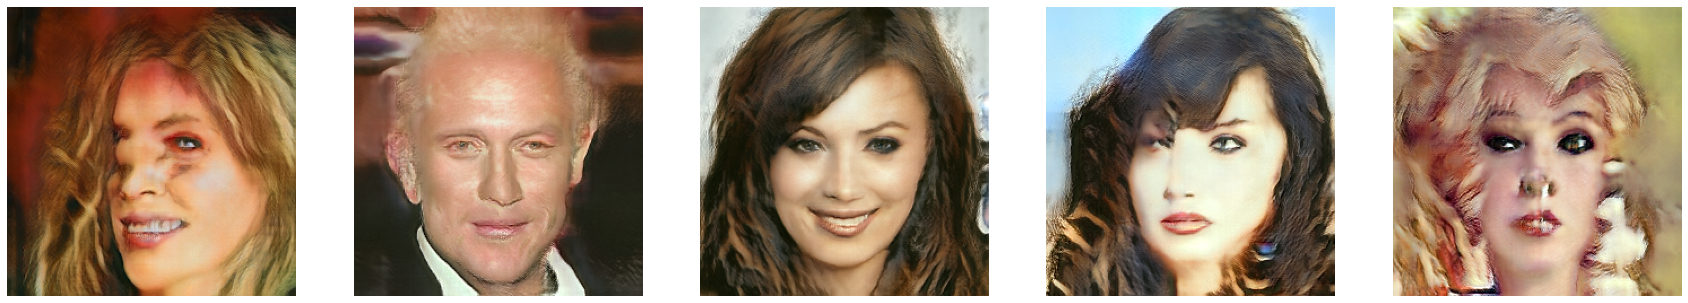

In [41]:
batch_size = 8
z = tf.random.truncated_normal((batch_size, 512))
w = style_gan.mapping(z)
noise = style_gan.generate_noise(batch_size)
images = style_gan.generate_images(style_code=w, noise=noise, alpha=1.)
plot_images(images, 8)

# Style Mixing

In [42]:
# Select style from above
idx_a = 1
idx_b = 2
w_a = np.expand_dims(w[idx_a], 0)
w_b = np.expand_dims(w[idx_b], 0)
noise_a = [np.expand_dims(n[idx_a],0) for n in noise]
noise_b = [np.expand_dims(n[idx_b],0) for n in noise]

image_a = style_gan.generate_images(style_code=w_a, noise=noise_a)[0]
image_b = style_gan.generate_images(style_code=w_b, noise=noise_b)[0]


In [43]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual


@interact
def explore_latent_variable(a0 = (0,1.0,0.05),
                            a1 = (0,1.0,0.05),
                            a2 = (0,1.0,0.05),
                            a3 = (0,1.0,0.05),
                            a4 = (0,1.0,0.05),
                            a5 = (0,1.0,0.05),
                            noise_src = widgets.Select(options=['Left', 'Right'], value='Left', 
                                                       description='Pose from:')
):
    style_a = np.mean(w_a, axis=(0,1))
    style_b = np.mean(w_b, axis=(0,1))
    alphas = [a0, a1, a2, a3, a4, a5]
    w_mix = np.expand_dims([alpha*style_a + (1-alpha)*style_b for alpha in alphas], 0)
    noise = noise_a if noise_src == 'Right' else noise_b
    image_mix = style_gan.generate_images(style_code=w_mix, noise=noise)[0]
    images = np.stack([image_b, image_a, image_mix])
    plot_images(images, 8)
    


interactive(children=(FloatSlider(value=0.5, description='a0', max=1.0, step=0.05), FloatSlider(value=0.5, des…

## Same Style, Different Noise

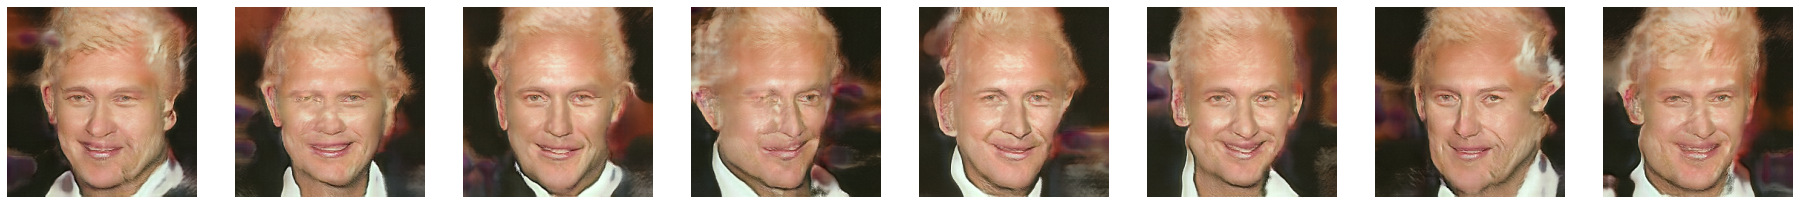

In [47]:
noise = style_gan.generate_noise(batch_size)
images = style_gan.generate_images(style_code=w_a, noise=noise)
plot_images(images, 6)
